# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
# import torch
from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.51123313.kevidu/ipykernel_434625/2601860326.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

In [5]:
# sns.color_palette("colorblind")
# print(sns.color_palette("colorblind").as_hex())

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

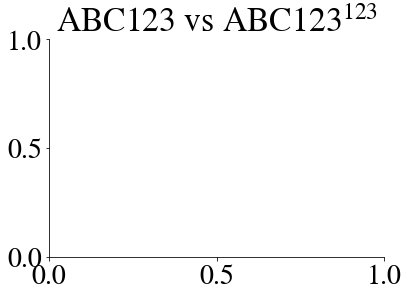

In [60]:
from mpl_styles import *

import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]


matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")

In [52]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s8.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [8]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s8.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 8, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entity_u

In [9]:
# Downloads yago_qec.json from wandb (if not already cached there)
artifact, files = load_artifact_from_wandb(
    f"{DATASET_NAME}-yago_qec", save_dir=Path(RAW_DATA_PATH).parent
)
artifact.name

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


'YagoECQ-yago_qec:v9'

In [10]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [11]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [12]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped


In [13]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [14]:
qid_to_artifact_path = {
    query_id: add_val_df_to_wandb(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

  0%|          | 0/125 [00:00<?, ?it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_about/schema_about-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  1%|          | 1/125 [00:00<00:57,  2.16it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_actor/schema_actor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
  2%|▏         | 2/125 [00:00<01:00,  2.04it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_address/schema_address-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  2%|▏         | 3/125 [00:01<01:00,  2.01it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_administrates/schema_administrates-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  3%|▎         | 4/125 [00:01<00:59,  2.05it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_affiliation/schema_affiliation-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  4%|▍         | 5/125 [00:02<00:56,  2.11it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
  5%|▍         | 6/125 [00:02<00:58,  2.03it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_author/schema_author-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  6%|▌         | 7/125 [00:03<00:56,  2.08it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_award/schema_award-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  6%|▋         | 8/125 [00:03<00:55,  2.13it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_birthDate/schema_birthDate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
  7%|▋         | 9/125 [00:04<00:53,  2.15it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_birthPlace/schema_birthPlace-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 1.6s
  8%|▊         | 10/125 [00:06<01:42,  1.12it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_children/schema_children-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


  9%|▉         | 11/125 [00:06<01:26,  1.32it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_contentLocation/schema_contentLocation-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 10%|▉         | 12/125 [00:07<01:15,  1.49it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_dateCreated/schema_dateCreated-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.8s
 10%|█         | 13/125 [00:08<01:29,  1.26it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_deathDate/schema_deathDate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 11%|█         | 14/125 [00:08<01:16,  1.46it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_deathPlace/schema_deathPlace-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 2.3s
 12%|█▏        | 15/125 [00:11<02:18,  1.26s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_demonym/schema_demonym-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 13%|█▎        | 16/125 [00:11<01:50,  1.02s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_director/schema_director-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 14%|█▎        | 17/125 [00:12<01:31,  1.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_dissolutionDate/schema_dissolutionDate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 14%|█▍        | 18/125 [00:12<01:16,  1.39it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_duns/schema_duns-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 15%|█▌        | 19/125 [00:12<01:07,  1.57it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_duration/schema_duration-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 16%|█▌        | 20/125 [00:13<01:02,  1.69it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_editor/schema_editor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 17%|█▋        | 21/125 [00:13<00:57,  1.82it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_elevation/schema_elevation-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.8s
 18%|█▊        | 22/125 [00:14<01:10,  1.46it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_endDate/schema_endDate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 18%|█▊        | 23/125 [00:15<01:04,  1.59it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_founder/schema_founder-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 19%|█▉        | 24/125 [00:15<00:56,  1.78it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.0s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 20%|██        | 25/125 [00:20<02:56,  1.76s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_highestPoint/schema_highestPoint-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 21%|██        | 26/125 [00:20<02:18,  1.39s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_homeLocation/schema_homeLocation-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 22%|██▏       | 27/125 [00:21<02:02,  1.25s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_humanDevelopmentIndex/schema_humanDevelopmentIndex-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 22%|██▏       | 28/125 [00:22<01:38,  1.02s/it]wandb: Adding directory to artifact (./data/YagoECQ/schema_iataCode/schema_iataCode-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 23%|██▎       | 29/125 [00:22<01:22,  1.17it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_icaoCode/schema_icaoCode-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 24%|██▍       | 30/125 [00:23<01:10,  1.35it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_illustrator/schema_illustrator-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 25%|██▍       | 31/125 [00:23<01:03,  1.49it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_inLanguage/schema_inLanguage-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 26%|██▌       | 32/125 [00:24<00:55,  1.68it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_influencedBy/schema_influencedBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.4s
 26%|██▋       | 33/125 [00:24<00:56,  1.62it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_isbn/schema_isbn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 27%|██▋       | 34/125 [00:25<00:51,  1.77it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_iswcCode/schema_iswcCode-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.1s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 28%|██▊       | 35/125 [00:25<00:45,  1.97it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_knowsLanguage/schema_knowsLanguage-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 29%|██▉       | 36/125 [00:26<00:45,  1.96it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_leader/schema_leader-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 30%|██▉       | 37/125 [00:26<00:42,  2.06it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_leiCode/schema_leiCode-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 30%|███       | 38/125 [00:26<00:40,  2.15it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_locationCreated/schema_locationCreated-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 31%|███       | 39/125 [00:27<00:41,  2.05it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_lowestPoint/schema_lowestPoint-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 32%|███▏      | 40/125 [00:27<00:40,  2.09it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_lyricist/schema_lyricist-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 33%|███▎      | 41/125 [00:28<00:42,  1.99it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_manufacturer/schema_manufacturer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 34%|███▎      | 42/125 [00:28<00:40,  2.07it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_material/schema_material-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 34%|███▍      | 43/125 [00:29<00:38,  2.10it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_memberOf/schema_memberOf-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 35%|███▌      | 44/125 [00:29<00:38,  2.12it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.0s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 36%|███▌      | 45/125 [00:30<00:32,  2.48it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_musicBy/schema_musicBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 37%|███▋      | 46/125 [00:30<00:35,  2.24it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_nationality/schema_nationality-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 38%|███▊      | 47/125 [00:31<00:36,  2.17it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_neighbors/schema_neighbors-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 38%|███▊      | 48/125 [00:31<00:35,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_numberOfEmployees/schema_numberOfEmployees-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 39%|███▉      | 49/125 [00:32<00:36,  2.10it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_numberOfEpisodes/schema_numberOfEpisodes-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 40%|████      | 50/125 [00:32<00:35,  2.11it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_numberOfPages/schema_numberOfPages-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 41%|████      | 51/125 [00:33<00:33,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_numberOfSeasons/schema_numberOfSeasons-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 42%|████▏     | 52/125 [00:33<00:34,  2.13it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_officialLanguage/schema_officialLanguage-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 42%|████▏     | 53/125 [00:34<00:33,  2.15it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_organizer/schema_organizer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 43%|████▎     | 54/125 [00:34<00:32,  2.20it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_ownedBy/schema_ownedBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 44%|████▍     | 55/125 [00:34<00:30,  2.26it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_owns/schema_owns-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 45%|████▍     | 56/125 [00:35<00:30,  2.28it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_parentTaxon/schema_parentTaxon-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 46%|████▌     | 57/125 [00:35<00:29,  2.34it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_performer/schema_performer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 46%|████▋     | 58/125 [00:36<00:29,  2.26it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_populationNumber/schema_populationNumber-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 47%|████▋     | 59/125 [00:36<00:29,  2.23it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_postalCode/schema_postalCode-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 48%|████▊     | 60/125 [00:37<00:28,  2.25it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_recordLabel/schema_recordLabel-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 49%|████▉     | 61/125 [00:37<00:28,  2.25it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_sponsor/schema_sponsor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.4s
 50%|████▉     | 62/125 [00:38<00:31,  2.01it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_spouse/schema_spouse-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 50%|█████     | 63/125 [00:38<00:28,  2.14it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_startDate/schema_startDate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 51%|█████     | 64/125 [00:38<00:28,  2.13it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_unemploymentRate/schema_unemploymentRate-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 52%|█████▏    | 65/125 [00:39<00:27,  2.16it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.0s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 53%|█████▎    | 66/125 [00:39<00:23,  2.51it/s]wandb: Adding directory to artifact (./data/YagoECQ/schema_worksFor/schema_worksFor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 54%|█████▎    | 67/125 [00:40<00:23,  2.42it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_academicDegree/yago_academicDegree-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 54%|█████▍    | 68/125 [00:40<00:23,  2.38it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_appearsIn/yago_appearsIn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 55%|█████▌    | 69/125 [00:41<00:24,  2.30it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_beliefSystem/yago_beliefSystem-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 56%|█████▌    | 70/125 [00:41<00:24,  2.22it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_candidateIn/yago_candidateIn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 57%|█████▋    | 71/125 [00:41<00:24,  2.22it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_capital/yago_capital-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 58%|█████▊    | 72/125 [00:42<00:23,  2.25it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_consumes/yago_consumes-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 58%|█████▊    | 73/125 [00:42<00:22,  2.30it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_director/yago_director-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.4s
 59%|█████▉    | 74/125 [00:43<00:26,  1.96it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_distanceFromEarth/yago_distanceFromEarth-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 60%|██████    | 75/125 [00:43<00:24,  2.02it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_doctoralAdvisor/yago_doctoralAdvisor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 61%|██████    | 76/125 [00:44<00:23,  2.09it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_flowsInto/yago_flowsInto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 62%|██████▏   | 77/125 [00:44<00:24,  1.98it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_follows/yago_follows-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 62%|██████▏   | 78/125 [00:45<00:23,  1.98it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_length/yago_length-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 63%|██████▎   | 79/125 [00:45<00:21,  2.10it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_luminosity/yago_luminosity-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 64%|██████▍   | 80/125 [00:46<00:21,  2.07it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_mass/yago_mass-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 65%|██████▍   | 81/125 [00:46<00:21,  2.02it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_notableWork/yago_notableWork-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 66%|██████▌   | 82/125 [00:47<00:20,  2.09it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_parallax/yago_parallax-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 66%|██████▋   | 83/125 [00:47<00:19,  2.13it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_parentBody/yago_parentBody-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 67%|██████▋   | 84/125 [00:48<00:19,  2.15it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_participant/yago_participant-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 68%|██████▊   | 85/125 [00:48<00:19,  2.10it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_playsIn/yago_playsIn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 69%|██████▉   | 86/125 [00:49<00:18,  2.12it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_radialVelocity/yago_radialVelocity-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 70%|██████▉   | 87/125 [00:49<00:17,  2.16it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_replaces/yago_replaces-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 70%|███████   | 88/125 [00:50<00:16,  2.25it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_sportNumber/yago_sportNumber-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 71%|███████   | 89/125 [00:50<00:16,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_studentOf/yago_studentOf-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 72%|███████▏  | 90/125 [00:51<00:19,  1.84it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_studentsCount/yago_studentsCount-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 73%|███████▎  | 91/125 [00:51<00:17,  1.90it/s]wandb: Adding directory to artifact (./data/YagoECQ/yago_terminus/yago_terminus-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 74%|███████▎  | 92/125 [00:52<00:16,  2.04it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_actor/reverse-schema_actor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 74%|███████▍  | 93/125 [00:52<00:14,  2.14it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_author/reverse-schema_author-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 75%|███████▌  | 94/125 [00:53<00:14,  2.12it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 76%|███████▌  | 95/125 [00:53<00:13,  2.20it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_editor/reverse-schema_editor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 77%|███████▋  | 96/125 [00:54<00:14,  2.07it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_founder/reverse-schema_founder-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 78%|███████▊  | 97/125 [00:54<00:13,  2.13it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_homeLocation/reverse-schema_homeLocation-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 78%|███████▊  | 98/125 [00:55<00:13,  2.01it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_illustrator/reverse-schema_illustrator-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 79%|███████▉  | 99/125 [00:55<00:12,  2.03it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_leader/reverse-schema_leader-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 80%|████████  | 100/125 [00:55<00:12,  2.07it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_lyricist/reverse-schema_lyricist-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 81%|████████  | 101/125 [00:56<00:11,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_manufacturer/reverse-schema_manufacturer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 82%|████████▏ | 102/125 [00:56<00:10,  2.24it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_memberOf/reverse-schema_memberOf-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 82%|████████▏ | 103/125 [00:57<00:10,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_musicBy/reverse-schema_musicBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 83%|████████▎ | 104/125 [00:57<00:09,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_organizer/reverse-schema_organizer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 84%|████████▍ | 105/125 [00:58<00:09,  2.18it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_ownedBy/reverse-schema_ownedBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 85%|████████▍ | 106/125 [00:58<00:08,  2.15it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_owns/reverse-schema_owns-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 86%|████████▌ | 107/125 [00:59<00:08,  2.17it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_parentTaxon/reverse-schema_parentTaxon-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 1.3s
 86%|████████▋ | 108/125 [01:00<00:13,  1.26it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_performer/reverse-schema_performer-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 87%|████████▋ | 109/125 [01:01<00:11,  1.43it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_sponsor/reverse-schema_sponsor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 88%|████████▊ | 110/125 [01:01<00:09,  1.61it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-schema_worksFor/reverse-schema_worksFor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 1.1s
 89%|████████▉ | 111/125 [01:02<00:11,  1.20it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_appearsIn/reverse-yago_appearsIn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 90%|████████▉ | 112/125 [01:03<00:09,  1.40it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_capital/reverse-yago_capital-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 90%|█████████ | 113/125 [01:03<00:07,  1.53it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_conferredBy/reverse-yago_conferredBy-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 91%|█████████ | 114/125 [01:04<00:06,  1.72it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_consumes/reverse-yago_consumes-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 92%|█████████▏| 115/125 [01:04<00:05,  1.88it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_director/reverse-yago_director-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.3s
 93%|█████████▎| 116/125 [01:05<00:04,  1.90it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_doctoralAdvisor/reverse-yago_doctoralAdvisor-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 94%|█████████▎| 117/125 [01:05<00:04,  1.98it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_flowsInto/reverse-yago_flowsInto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 94%|█████████▍| 118/125 [01:06<00:03,  2.04it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_notableWork/reverse-yago_notableWork-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.4s
 95%|█████████▌| 119/125 [01:06<00:03,  1.90it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_parentBody/reverse-yago_parentBody-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... Done. 0.2s


Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


 96%|█████████▌| 120/125 [01:07<00:02,  2.04it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_participant/reverse-yago_participant-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 97%|█████████▋| 121/125 [01:07<00:01,  2.06it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_playsIn/reverse-yago_playsIn-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 98%|█████████▊| 122/125 [01:08<00:01,  2.10it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_replaces/reverse-yago_replaces-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 98%|█████████▊| 123/125 [01:08<00:00,  2.11it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_studentOf/reverse-yago_studentOf-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
 99%|█████████▉| 124/125 [01:09<00:00,  2.12it/s]wandb: Adding directory to artifact (./data/YagoECQ/reverse-yago_terminus/reverse-yago_terminus-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results)... 

Logging results to w&b run <wandb.sdk.wandb_run.Run object at 0x2ab1a27b9900>.


Done. 0.2s
100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


In [15]:
# query_ids = list(
#     set(query_ids).difference(
#         [
#             # "http://yago-knowledge.org/resource/studentsCount",
#             # "http://schema.org/numberOfPages",
#             "http://yago-knowledge.org/resource/distanceFromEarth",
#             # "http://schema.org/numberOfEmployees",
#             # "http://schema.org/numberOfEpisodes",
#             # "http://schema.org/numberOfSeasons",
#             # "http://schema.org/humanDevelopmentIndex",
#             "http://schema.org/duns",
#             # "http://schema.org/duration",
#             "http://schema.org/unemploymentRate",
#             "http://yago-knowledge.org/resource/radialVelocity",
#             # "http://schema.org/populationNumber",
#             "http://yago-knowledge.org/resource/luminosity",
#             "http://yago-knowledge.org/resource/parallax",
#             "http://yago-knowledge.org/resource/length",
#             "http://schema.org/elevation",
#             # "http://yago-knowledge.org/resource/sportNumber",
#             "http://yago-knowledge.org/resource/mass",
#         ]
#         # [
#         #     "http://yago-knowledge.org/resource/studentsCount",
#         #     "http://schema.org/numberOfPages",
#         #     "http://yago-knowledge.org/resource/distanceFromEarth",
#         #     "http://schema.org/numberOfEmployees",
#         #     "http://schema.org/numberOfEpisodes",
#         #     "http://schema.org/numberOfSeasons",
#         #     "http://schema.org/humanDevelopmentIndex",
#         #     "http://schema.org/duns",
#         #     "http://schema.org/duration",
#         #     "http://schema.org/unemploymentRate",
#         #     "http://yago-knowledge.org/resource/radialVelocity",
#         #     "http://schema.org/populationNumber",
#         #     "http://yago-knowledge.org/resource/luminosity",
#         #     "http://yago-knowledge.org/resource/parallax",
#         #     "http://yago-knowledge.org/resource/length",
#         #     "http://schema.org/elevation",
#         #     "http://yago-knowledge.org/resource/sportNumber",
#         #     "http://yago-knowledge.org/resource/mass",
#         # ]
#     )
# )
# # qid_to_results_paths = {
# #     query_id: load_val_df_from_wandb(
# #         **DATASET_KWARGS,
# #         QUERY_ID=query_id,
# #         verbose=False,
# #         overwrite_df=True,
# #     )
# #     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
# #     for query_id in tqdm(query_ids)
# # }

In [16]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://schema.org/actor",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   contexts               400 non-null    object 
 5   persuasion_scores      400 non-null    object 
 6   persuasion_scores_kl   400 non-null    object 
 7   type                   400 non-null    object 
 8   susceptibility_score   400 non-null    float64
 9   sampled_mr             400 non-null    float64
 10  sampled_answergroups   400 non-null    object 
 11  sampled_outputs        400 non-null    object 
 12  entity_classes         400 non-null    object 
 13  query_type             400 non-null    object 
 14  relev

In [17]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

  2%|▏         | 2/125 [00:04<04:09,  2.03s/it]

Computing val_df_per_qe for http://schema.org/address.
Unable to find mr_results_path at data/YagoECQ/schema_address/schema_address-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/mr.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_address/schema_address-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/mr.csv'


 14%|█▍        | 18/125 [00:35<03:32,  1.98s/it]

Computing val_df_per_qe for http://schema.org/duns.


 17%|█▋        | 21/125 [00:41<03:27,  2.00s/it]

Computing val_df_per_qe for http://schema.org/elevation.


 19%|█▉        | 24/125 [00:48<03:36,  2.14s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 35%|███▌      | 44/125 [01:25<02:29,  1.85s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 51%|█████     | 64/125 [02:02<02:02,  2.00s/it]

Computing val_df_per_qe for http://schema.org/unemploymentRate.


 52%|█████▏    | 65/125 [02:05<02:19,  2.33s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 59%|█████▉    | 74/125 [02:22<01:49,  2.14s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/distanceFromEarth.


 62%|██████▏   | 78/125 [02:32<01:49,  2.33s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/length.


 63%|██████▎   | 79/125 [02:35<01:52,  2.44s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/luminosity.


 64%|██████▍   | 80/125 [02:38<02:03,  2.75s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/mass.


 66%|██████▌   | 82/125 [02:44<01:53,  2.65s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/parallax.


 69%|██████▉   | 86/125 [02:53<01:34,  2.43s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/radialVelocity.


100%|██████████| 125/125 [04:21<00:00,  2.09s/it]


In [18]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/gtin', 'http://schema.org/motto', 'http://schema.org/url'}


In [19]:
# # Temporary fix for yago_qec and df having different lists of fake entiites
# for qid, val_df_per_qe in qid_to_val_df_per_qe.items():
#     val_df_per_qe["type"] = val_df_per_qe["type"].fillna("gpt_fake_entities")
#     qid_to_val_df_per_qe[qid] = val_df_per_qe

In [20]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
323,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Gott erhalte Franz den Kaiser,)",Lorenz Leopold Haschka,[A lyricist for 'Across the Universe' is a Caz...,"[0.29490184783935547, 0.4574427604675293, 1.24...","[0.480533994299495, 0.2994642013147998, 0.6675...",entities,0.815419,{'http://schema.org/CreativeWork': 0.740740740...,open,"[180, 181, 182, 183, 184]"
308,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Amhrán na bhFiann,)",Peadar Kearney,[A lyricist for 'Across the Universe' is a Caz...,"[0.9080157279968262, 0.29494380950927734, 1.37...","[0.6777028330396617, 0.23465810606651763, 0.79...",entities,0.844593,{'http://schema.org/CreativeWork': 0.740740740...,open,"[15, 16, 17, 18, 19]"
346,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Lucy in the Sky with Diamonds,)",John Lennon,[A lyricist for 'Across the Universe' is a Caz...,"[0.5486249923706055, 0.6428766250610352, 1.889...","[0.988235430769374, 0.4358658853149478, 0.8458...",entities,0.902412,{'http://schema.org/CreativeWork': 0.740740740...,open,"[260, 261, 262, 263, 264]"
331,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Take Me Home, Country Roads,)",John Denver,[A lyricist for 'Across the Universe' is a Caz...,"[0.13915395736694336, 0.30098867416381836, 3.8...","[1.0706250568769844, 0.22521980203515946, 1.16...",entities,0.945097,{'http://schema.org/CreativeWork': 0.740740740...,open,"[390, 391, 392, 393, 394]"
334,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Mamma Mia!,)",Benny Andersson,[A lyricist for 'Across the Universe' is a Caz...,"[1.0923986434936523, 1.3014211654663086, 1.594...","[1.4268034372582383, 0.4066025009529771, 0.625...",entities,0.949211,{'http://schema.org/CreativeWork': 0.740740740...,open,"[265, 266, 267, 268, 269]"


In [21]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [22]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 122/122 [00:00<00:00, 197.67it/s]


[384, 376, 332, 324, 296, 280, 384, 308, 280, 280, 280, 384, 316, 280, 280, 336, 384, 320, 360, 384, 388, 288, 392, 320, 336, 280, 328, 352, 308, 396, 396, 280, 392, 396, 284, 320, 344, 380, 312, 384, 396, 392, 280, 388, 280, 312, 328, 388, 400, 380, 320, 392, 308, 276, 400, 316, 320, 328, 340, 392, 280, 392, 324, 272, 324, 308, 288, 280, 324, 388, 356, 308, 280, 308, 392, 308, 308, 308, 280, 308, 308, 392, 280, 308, 336, 292, 300, 336, 308, 280, 292, 280, 304, 280, 316, 312, 288, 280, 332, 352, 280, 340, 308, 372, 400, 280, 328, 340, 392, 312, 344, 400, 324, 280, 308, 384, 308, 340, 392, 324, 296, 340]


### Susceptibility Scores: real vs fake

In [23]:
from analysis_helpers import (
    compute_ttest_scores_dfs,
    save_ttest_df_to_json,
    count_open_closed_sig_group_match,
    count_num_significant_queries,
    combine_open_and_closed_dfs,
    write_to_latex_test_results_by_qid,
    write_to_latex_test_sus_and_per_results_by_qid,
)

In [24]:
ttest_res_open_sus_df, ttest_res_closed_sus_df = compute_ttest_scores_dfs(
    qid_to_val_df_per_qe,
    group1="entities",
    group2="gpt_fake_entities",
    score_col="susceptibility_score",
    permutations=10000,
)

100%|██████████| 122/122 [00:06<00:00, 19.13it/s]


In [25]:
save_ttest_df_to_json(
    ttest_res_open_sus_df,
    ttest_res_closed_sus_df,
    qid_to_val_df_per_qe,
    analysis_dir=analysis_dir,
    filename="qid_to_sus_ttest_res_and_entities.json",
)

analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped/qid_to_sus_ttest_res_and_entities.json


In [26]:
# Number of queries with matching significance results
count_open_closed_sig_group_match(ttest_res_open_sus_df, ttest_res_closed_sus_df)

,query,open,closed
0,http://schema.org/spouse,less,less
1,http://yago-knowledge.org/resource/notableWork,less,less
2,http://schema.org/iataCode,less,less
7,reverse-http://schema.org/manufacturer,less,less
9,http://yago-knowledge.org/resource/doctoralAdv...,less,less
...,...,...,...
108,http://schema.org/nationality,not,not
109,http://schema.org/knowsLanguage,not,not
111,reverse-http://yago-knowledge.org/resource/con...,not,not
113,http://schema.org/about,not,not


In [27]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_sus_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_sus_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "less": 76,
    "insignificant": 46
  },
  "proportion": {
    "less": 0.6229508196721312,
    "insignificant": 0.3770491803278688
  }
}


Closed:
{
  "count": {
    "less": 69,
    "insignificant": 53
  },
  "proportion": {
    "less": 0.5655737704918032,
    "insignificant": 0.4344262295081967
  }
}


In [28]:
sus_score_test_results_by_qid = combine_open_and_closed_dfs(
    ttest_res_open_sus_df, ttest_res_closed_sus_df
)
sus_score_test_results_by_qid

Open              Closed        
                 Cohen's $d$     $p$ Cohen's $d$     $p$
Query                                                   
about               0.103299  0.7660   -0.182118  0.1004
academicDegree     -0.257908  0.0592   -0.932721  0.0000
actor              -1.231688  0.0000   -0.307830  0.0207
address            -0.337779  0.0170    0.449756  0.9987
administrates       0.127950  0.7893   -0.690885  0.0000
...                      ...     ...         ...     ...
studentOf          -0.366294  0.0192   -0.425782  0.0091
studentsCount      -1.188603  0.0000   -0.009478  0.4700
terminus            0.276667  0.9436   -0.954789  0.0000
unemploymentRate   -0.772067  0.0000    0.080378  0.6866
worksFor           -0.563388  0.0024   -0.829183  0.0000

[122 rows x 4 columns]

In [29]:
print(
    write_to_latex_test_results_by_qid(
        sus_score_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="sus_score_test_results_by_qid.tex",
    )[:500]
)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  \\
\midrule
about & 0.10 & 0.77 & -0.18 & 0.10 \\
academicDegree & -0.26 & 0.06 & -0.93 & 0.00 \\
actor & -1.23 & 0.00 & -0.31 & 0.02 \\
address & -0.34 & 0.02 & 0.45 & 1.00 \\
administrates & 0.13 & 0.79 & -0.69 & 0.00 \\
affiliation & -0.40 & 0.01 & -0.33 & 0.03 \\
alumniOf & -0.27 & 0.08 & -0.58 & 0.00 \\
appearsIn & -0.42 & 0.01 & -0.33 & 0


/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/tmp.51123313.kevidu/ipykernel_434625/1008532667.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=["(a)", "(b)"])


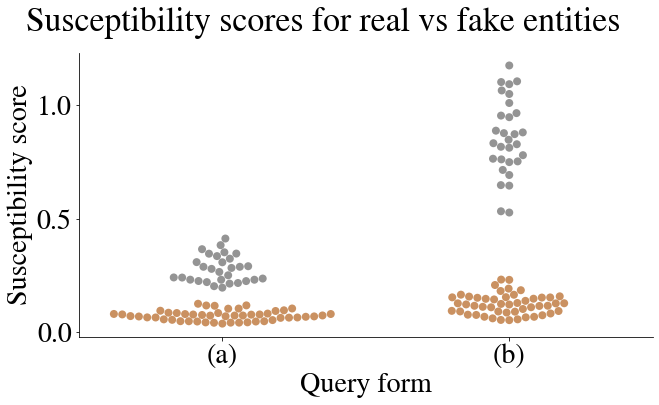

In [61]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
}

qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6.5))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    plot = sns.swarmplot(
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        size=8,
        # hue="is_real",
        # dodge=True,
        hue_order=ENTITY_TYPES,
        legend=None,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=["(a)", "(b)"])
ax.set_xlabel("Query form")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility scores for real vs fake entities", y=0.9)
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the poin

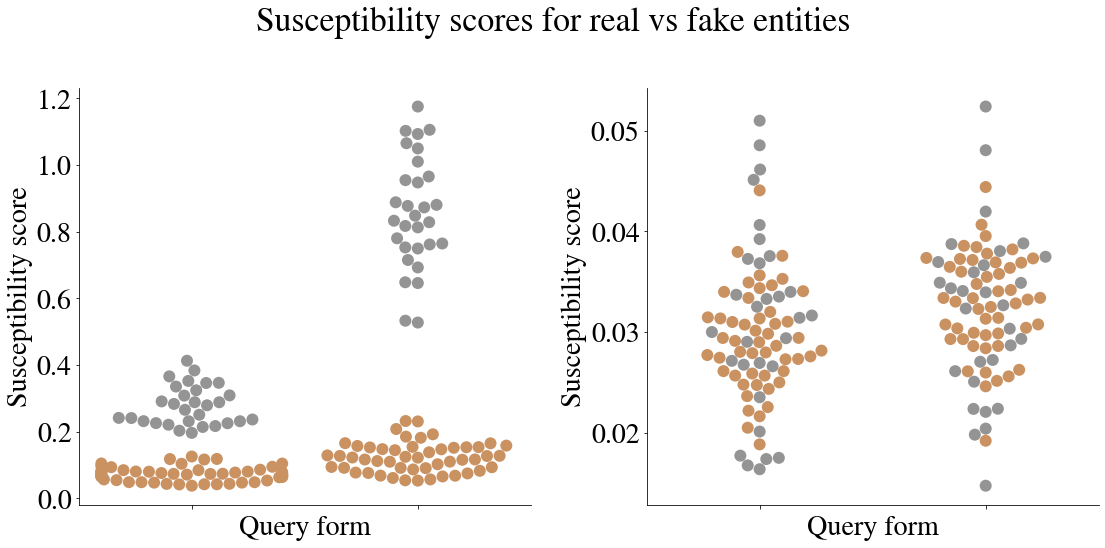

In [62]:
qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
    "closed": "http://schema.org/officialLanguage",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    ax = axes[i]
    plot = sns.swarmplot(
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        size=12,
        # hue="is_real",
        # dodge=True,
        hue_order=ENTITY_TYPES,
        legend=None,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        # legend="full",
    )
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(15)
    ax.set(xticklabels=[])
    ax.set_xlabel("Query form")
    ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility scores for real vs fake entities")
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

<Axes: xlabel='type', ylabel='susceptibility_score'>

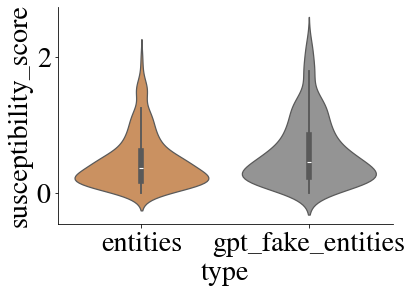

In [64]:
# Average sus score across all queries
val_dfs_all = pd.concat(list(qid_to_val_df_per_qe.values()), axis=0)
val_dfs_all
sus_scores_per_query_real_fake = (
    val_dfs_all.groupby(["q_id", "query_form", "query_type", "type"])
    .agg({"susceptibility_score": "mean"})
    .reset_index()
)
sns.violinplot(
    data=sus_scores_per_query_real_fake[
        sus_scores_per_query_real_fake["query_type"] == "open"
    ],
    x="type",
    y="susceptibility_score",
    hue="type",
    saturation=1.0,
    palette=[colormap[e] for e in ENTITY_TYPES],
)

/scratch/tmp.51123313.kevidu/ipykernel_434625/2959530097.py:22: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(


<Axes: xlabel='type', ylabel='diff'>

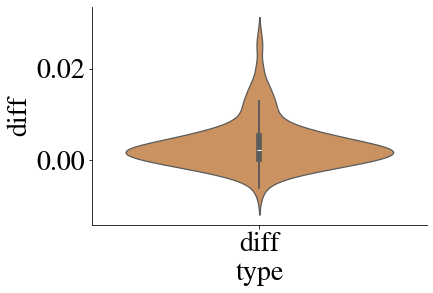

In [114]:
# Plot diff
sus_scores_per_query_fake = (
    sus_scores_per_query_real_fake[
        sus_scores_per_query_real_fake["type"] == "gpt_fake_entities"
    ]
    .sort_values(["q_id", "query_form", "query_type", "type"])
    .reset_index(drop=True)
)
sus_scores_per_query_fake
sus_scores_per_query_real = (
    sus_scores_per_query_real_fake[sus_scores_per_query_real_fake["type"] == "entities"]
    .sort_values(["q_id", "query_form", "query_type", "type"], inplace=False)
    .reset_index(drop=True)
)
sus_scores_per_query_real
sus_scores_per_query_fake["diff"] = (
    sus_scores_per_query_fake["susceptibility_score"]
    - sus_scores_per_query_real["susceptibility_score"]
)
sus_scores_per_query_fake["type"] = "diff"
sus_scores_per_query_fake
sns.violinplot(
    data=sus_scores_per_query_fake[sus_scores_per_query_fake["query_type"] == "closed"],
    x="type",
    y="diff",
    hue="type",
    saturation=1.0,
    palette=[colormap[e] for e in ENTITY_TYPES],
)

In [33]:
# # Plot every 10th query swarmplot, increasing according to the p-value
# qid_to_df_and_open_pvals = {
#     ttest_res_open_sus_df.iloc[i]["query"]: (
#         ttest_res_open_sus_df.iloc[i]["p_value"],
#         qid_to_val_df_per_qe[ttest_res_open_sus_df.iloc[i]["query"]],
#     )
#     for i in range(0, len(ttest_res_open_sus_df), 10)
# }

# fig, axes = plt.subplots(
#     nrows=len(qid_to_df_and_open_pvals), ncols=1, figsize=(10, 120)
# )

# for i, (qid, (p_value, df)) in enumerate(qid_to_df_and_open_pvals.items()):
#     ax = axes[i]
#     plot = sns.swarmplot(
#         # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
#         data=df[df["query_type"] == "open"],
#         x="query_form",
#         y="susceptibility_score",
#         hue="type",
#         ax=ax,
#         size=12,
#         dodge=True,
#         hue_order=ENTITY_TYPES,
#         palette=[colormap[e] for e in ENTITY_TYPES],
#     )
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(15)
#     ax.set_xlabel("Query form")
#     ax.set_ylabel("Susceptibility score")
#     ax.set_title(f"qid={qid}, pval={p_value:.3f}")
# fig.suptitle("Susceptibility scores for real entities vs fake entities")
# plt.tight_layout()
# plot_name = f"plot_susscore_vs_queryform_real_fake_open_increasing_pval"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path, bbox_inches="tight")

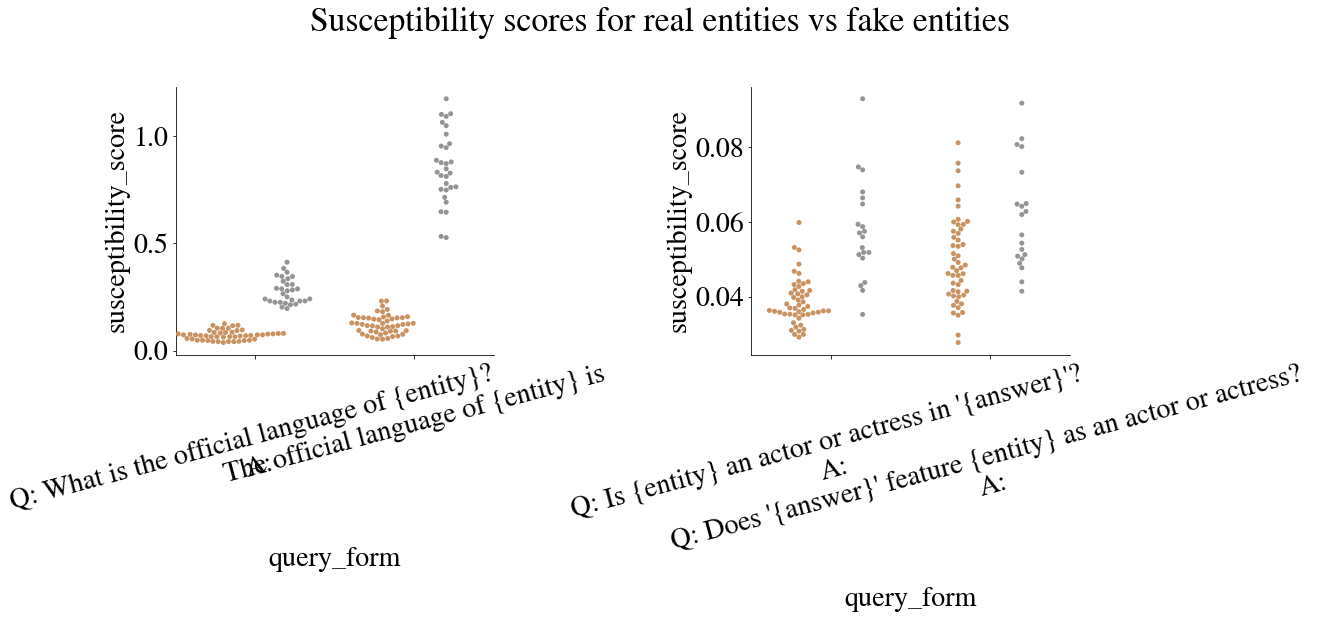

In [115]:
qt_to_qids = {
    "open": "http://schema.org/officialLanguage",
    "closed": "reverse-http://schema.org/actor",
}
qt_to_dfs = {qt: qid_to_val_df_per_qe[qid] for qt, qid in qt_to_qids.items()}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

for i, (qt, df) in enumerate(qt_to_dfs.items()):
    ax = axes[i]
    plot = sns.swarmplot(
        # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
        data=df[df["query_type"] == qt],
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # size=5,
        # hue="is_real",
        dodge=True,
        hue_order=ENTITY_TYPES,
        palette=[colormap[e] for e in ENTITY_TYPES],
        # jitter=0.1,
        legend=None,
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
fig.suptitle("Susceptibility scores for real entities vs fake entities")
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_open_and_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
# wandb.log({plot_name: wandb.Image(fig)})
# df.iloc[0]["contexts"]

### Persuasion scores (relevant vs irrelevant)

In [34]:
df["relevant_context_inds"].iloc[0]

[10, 11, 12, 13, 14]

In [116]:
def mean_relevant_and_irrelevant_persuasion_scores(
    persuasion_scores: List[float], relevant_context_inds: List[int]
):
    persuasion_scores = np.array(persuasion_scores)

    relevant_p_scores = persuasion_scores[relevant_context_inds]
    irrelevant_p_scores = np.delete(persuasion_scores, relevant_context_inds)
    return (
        np.mean(relevant_p_scores),
        np.mean(irrelevant_p_scores),
        relevant_p_scores,
        irrelevant_p_scores,
    )


for query_id, df in qid_to_val_df_per_qe.items():
    df["mean_relevant_p_score"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[0],
        axis=1,
    )
    df["mean_irrelevant_p_score"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[1],
        axis=1,
    )
    df["relevant_p_scores"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[2],
        axis=1,
    )
    df["irrelevant_p_scores"] = df.apply(
        lambda x: mean_relevant_and_irrelevant_persuasion_scores(
            x["persuasion_scores_kl"], x["relevant_context_inds"]
        )[3],
        axis=1,
    )
    qid_to_val_df_per_qe[query_id] = df

qid_to_pscore_df = {
    qid: df[
        ["query_type", "query_form", "mean_relevant_p_score", "mean_irrelevant_p_score"]
    ].melt(
        id_vars=["query_type", "query_form"],
        var_name="type",
        value_name="persuasion_score",
    )
    for qid, df in qid_to_val_df_per_qe.items()
}

/scratch/tmp.51123313.kevidu/ipykernel_434625/1346217601.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mean_relevant_p_score"] = df.apply(
/scratch/tmp.51123313.kevidu/ipykernel_434625/1346217601.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mean_irrelevant_p_score"] = df.apply(
/scratch/tmp.51123313.kevidu/ipykernel_434625/1346217601.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='query_form', ylabel='persuasion_score'>

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


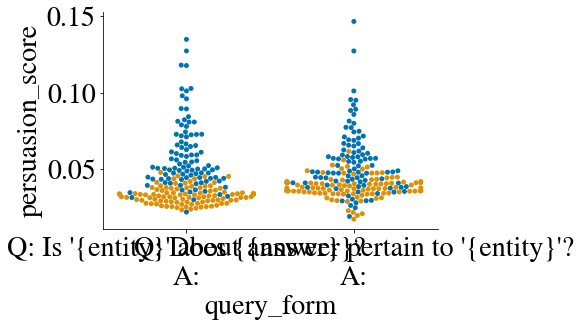

In [117]:
pscore_df = next(iter(qid_to_pscore_df.items()))[1]
sns.swarmplot(
    data=pscore_df[pscore_df["query_type"] == "closed"],
    x="query_form",
    y="persuasion_score",
    hue="type",
    legend=None,
)

In [118]:
mean_pscore_diffs = []
for qid, df in qid_to_pscore_df.items():
    wide_relevant_vs_irr_pscore_df = (
        df.groupby(["query_form", "type", "query_type"])
        .agg({"persuasion_score": "mean"})
        .reset_index()
        .pivot(
            index=["query_form", "query_type"],
            columns=["type"],
            values=["persuasion_score"],
        )
        .reset_index()
    )
    wide_relevant_vs_irr_pscore_df["pscore_diff"] = (
        wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_relevant_p_score")]
        - wide_relevant_vs_irr_pscore_df[
            ("persuasion_score", "mean_irrelevant_p_score")
        ]
    )
    wide_relevant_vs_irr_pscore_df[
        "mean_relevant_p_score"
    ] = wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_relevant_p_score")]
    wide_relevant_vs_irr_pscore_df[
        "mean_irrelevant_p_score"
    ] = wide_relevant_vs_irr_pscore_df[("persuasion_score", "mean_irrelevant_p_score")]

    wide_relevant_vs_irr_pscore_df["query"] = qid
    mean_pscore_diffs.append(
        wide_relevant_vs_irr_pscore_df[
            [
                "query",
                "query_type",
                "query_form",
                "pscore_diff",
                "mean_relevant_p_score",
                "mean_irrelevant_p_score",
            ]
        ]
    )

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


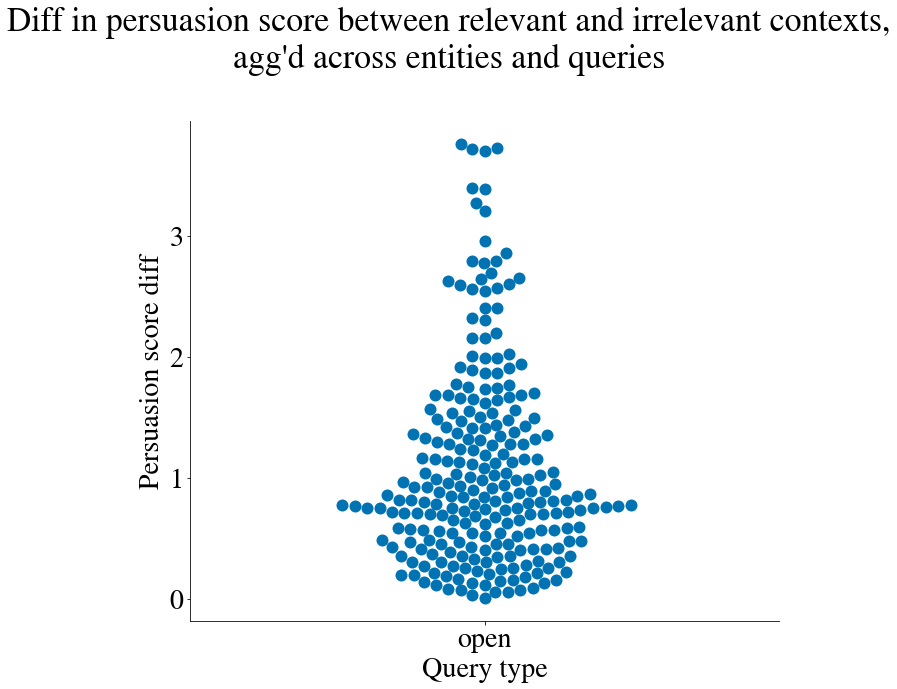

In [119]:
# Summary plot for the pscores across all queries (one dot is the pscore diff (averaged across all entities) for one query)
summary_pscores_across_queries = pd.concat(mean_pscore_diffs, axis=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(
    data=summary_pscores_across_queries[
        summary_pscores_across_queries["query_type"] == "open"
    ],
    x="query_type",
    y="pscore_diff",
    size=12,
    ax=ax,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Persuasion score diff")
fig.suptitle(
    "Diff in persuasion score between relevant and irrelevant contexts,\nagg'd across entities and queries"
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_agg_ents_and_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

# Convert MultiIndex columns to tuples
tuples = summary_pscores_across_queries.columns.to_flat_index()

# Join tuple elements into a single string separated by underscore
new_column_names = [tup[0] for tup in tuples]

# Assign new column names to the DataFrame
summary_pscores_across_queries.columns = new_column_names

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3398: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


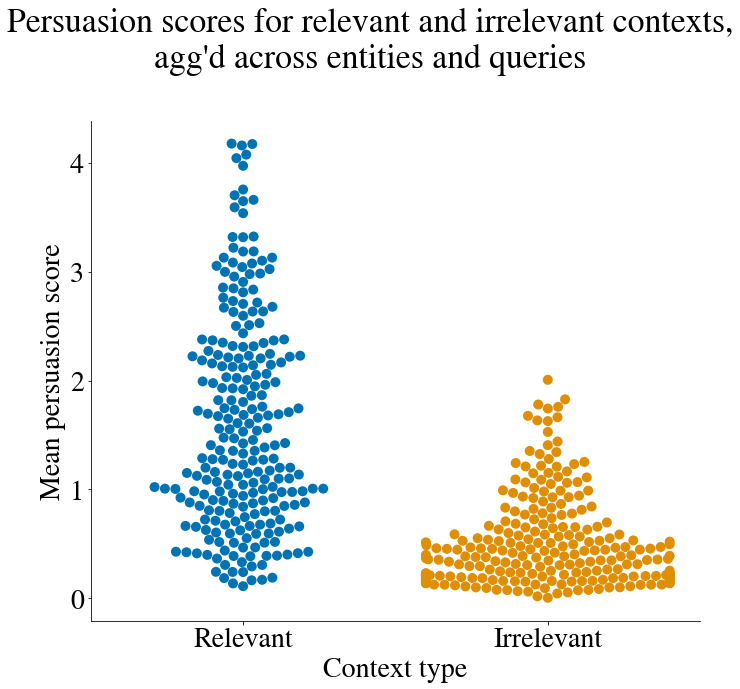

In [120]:
summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "Relevant",
    "mean_irrelevant_p_score": "Irrelevant",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, ax = plt.subplots(figsize=(10, 10))
sns.swarmplot(
    data=summary_pscores_across_queries_rel_and_irr[
        summary_pscores_across_queries_rel_and_irr["query_type"] == "open"
    ],
    x="presentable_context_type",
    y="persuasion_score",
    hue="presentable_context_type",
    size=10,
    # dodge=True,
    ax=ax,
)
ax.set_xlabel("Context type")
ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts,\nagg'd across entities and queries"
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_agg_ents_and_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

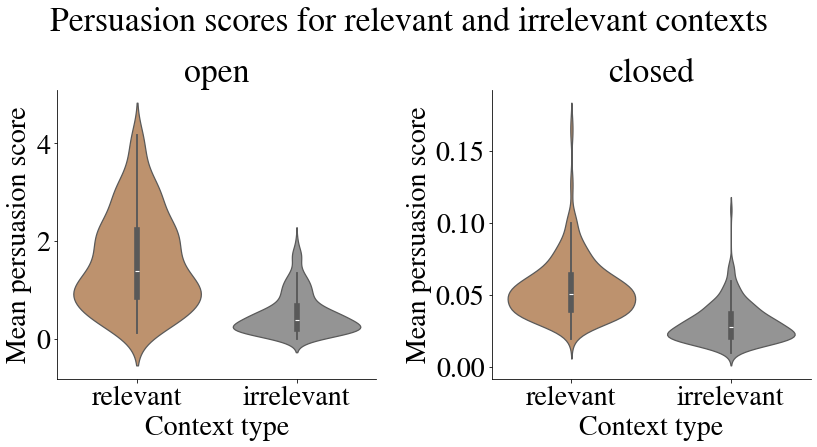

In [121]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
    "relevant": REAL_COLOR,
    "irrelevant": FAKE_COLOR,
}

summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "relevant",
    "mean_irrelevant_p_score": "irrelevant",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(
    summary_pscores_across_queries_rel_and_irr["query_type"].unique()
):
    ax = axes[i]
    sns.violinplot(
        data=summary_pscores_across_queries_rel_and_irr[
            summary_pscores_across_queries_rel_and_irr["query_type"] == qt
        ],
        x="presentable_context_type",
        y="persuasion_score",
        hue="presentable_context_type",
        # size=10,
        # dodge=True,
        palette=[
            colormap[c]
            for c in summary_pscores_across_queries_rel_and_irr[
                "presentable_context_type"
            ].unique()
        ],
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Context type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

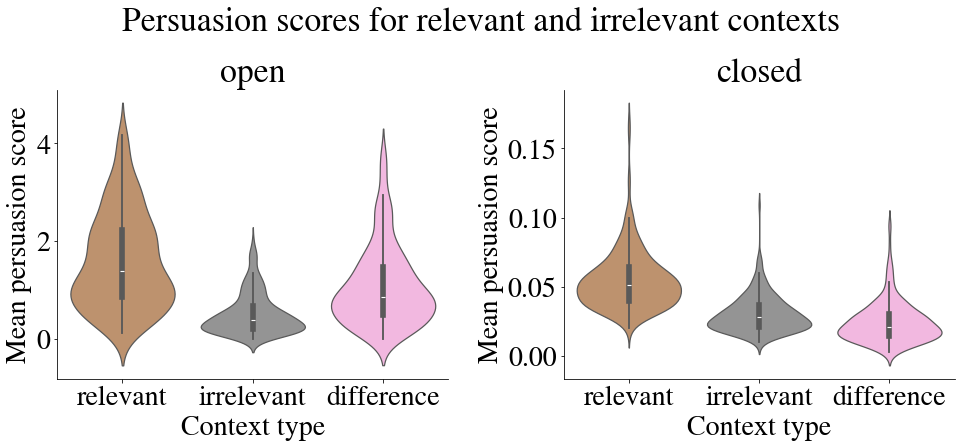

In [122]:
colormap = {
    "entities": REAL_COLOR,
    "gpt_fake_entities": FAKE_COLOR,
    "relevant": REAL_COLOR,
    "irrelevant": FAKE_COLOR,
    "difference": DIFF_COLOR,
}

summary_pscores_across_queries_rel_and_irr = summary_pscores_across_queries.melt(
    id_vars=["query", "query_form", "query_type"],
    value_vars=["mean_relevant_p_score", "mean_irrelevant_p_score", "pscore_diff"],
    var_name="context_type",
    value_name="persuasion_score",
)
context_type_to_presentable = {
    "mean_relevant_p_score": "relevant",
    "mean_irrelevant_p_score": "irrelevant",
    "pscore_diff": "difference",
}
summary_pscores_across_queries_rel_and_irr[
    "presentable_context_type"
] = summary_pscores_across_queries_rel_and_irr["context_type"].apply(
    lambda x: context_type_to_presentable[x]
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
for i, qt in enumerate(
    summary_pscores_across_queries_rel_and_irr["query_type"].unique()
):
    ax = axes[i]
    sns.violinplot(
        data=summary_pscores_across_queries_rel_and_irr[
            summary_pscores_across_queries_rel_and_irr["query_type"] == qt
        ],
        x="presentable_context_type",
        y="persuasion_score",
        hue="presentable_context_type",
        # size=10,
        # dodge=True,
        palette=[
            colormap[c]
            for c in summary_pscores_across_queries_rel_and_irr[
                "presentable_context_type"
            ].unique()
        ],
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Context type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores for relevant and irrelevant contexts",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_relevant_irrelevant_contexts_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [123]:
ttest_res_open_p_df, ttest_res_closed_p_df = compute_ttest_scores_dfs(
    qid_to_pscore_df,
    group1="mean_irrelevant_p_score",
    group2="mean_relevant_p_score",
    score_col="persuasion_score",
    permutations=10000,
)

100%|██████████| 122/122 [00:10<00:00, 11.82it/s]


In [124]:
count_open_closed_sig_group_match(ttest_res_open_p_df, ttest_res_closed_p_df)

,query,open,closed
0,http://schema.org/about,less,less
1,reverse-http://schema.org/actor,less,less
2,http://yago-knowledge.org/resource/terminus,less,less
3,http://yago-knowledge.org/resource/studentsCount,less,less
4,http://yago-knowledge.org/resource/studentOf,less,less
...,...,...,...
117,http://yago-knowledge.org/resource/candidateIn,less,less
118,http://schema.org/knowsLanguage,less,less
119,http://yago-knowledge.org/resource/appearsIn,less,less
120,reverse-http://yago-knowledge.org/resource/ter...,less,less


In [125]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="greater",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="greater",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "insignificant": 122,
    "more": 0
  },
  "proportion": {
    "insignificant": 1.0,
    "more": 0.0
  }
}


Closed:
{
  "count": {
    "insignificant": 122,
    "more": 0
  },
  "proportion": {
    "insignificant": 1.0,
    "more": 0.0
  }
}


In [126]:
p_score_test_results_by_qid = combine_open_and_closed_dfs(
    ttest_res_open_p_df, ttest_res_closed_p_df
)
p_score_test_results_by_qid

Open              Closed        
                 Cohen's $d$     $p$ Cohen's $d$     $p$
Query                                                   
about              -0.870362  0.0000   -1.323989  0.0000
academicDegree     -0.209945  0.0304   -0.536073  0.0000
actor              -2.100539  0.0000   -1.400225  0.0000
address            -1.578151  0.0000   -1.344261  0.0000
administrates      -1.525502  0.0000   -0.917035  0.0000
...                      ...     ...         ...     ...
studentOf          -1.708056  0.0000   -1.471484  0.0000
studentsCount      -2.298804  0.0000   -1.348897  0.0000
terminus           -0.810909  0.0000   -0.485346  0.0000
unemploymentRate   -2.236756  0.0000   -0.202781  0.0336
worksFor           -1.774357  0.0000   -1.626759  0.0000

[122 rows x 4 columns]

In [127]:
print(
    write_to_latex_test_results_by_qid(
        p_score_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="p_score_test_results_by_qid.tex",
    )[:500]
)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  \\
\midrule
about & -0.87 & 0.00 & -1.32 & 0.00 \\
academicDegree & -0.21 & 0.03 & -0.54 & 0.00 \\
actor & -2.10 & 0.00 & -1.40 & 0.00 \\
address & -1.58 & 0.00 & -1.34 & 0.00 \\
administrates & -1.53 & 0.00 & -0.92 & 0.00 \\
affiliation & -0.98 & 0.00 & -2.06 & 0.00 \\
alumniOf & -1.76 & 0.00 & -2.42 & 0.00 \\
appearsIn & -0.35 & 0.00 & -0.94 


In [128]:
sus_and_persuasion_test_results_by_qid = pd.concat(
    [
        sus_score_test_results_by_qid,
        p_score_test_results_by_qid,
    ],
    keys=["Susceptibility", "Persuasion"],
    axis=1,
)
sus_and_persuasion_test_results_by_qid

Susceptibility                              Persuasion  \
                           Open              Closed                Open   
                    Cohen's $d$     $p$ Cohen's $d$     $p$ Cohen's $d$   
Query                                                                     
about                  0.103299  0.7660   -0.182118  0.1004   -0.870362   
academicDegree        -0.257908  0.0592   -0.932721  0.0000   -0.209945   
actor                 -1.231688  0.0000   -0.307830  0.0207   -2.100539   
address               -0.337779  0.0170    0.449756  0.9987   -1.578151   
administrates          0.127950  0.7893   -0.690885  0.0000   -1.525502   
...                         ...     ...         ...     ...         ...   
studentOf             -0.366294  0.0192   -0.425782  0.0091   -1.708056   
studentsCount         -1.188603  0.0000   -0.009478  0.4700   -2.298804   
terminus               0.276667  0.9436   -0.954789  0.0000   -0.810909   
unemploymentRate      -0.772067  0.0000    0.080378  0.6866   -2.236756   
worksFor              -0.563388  0.0024   -0.829183  0.0000   -1.774357   

                                              
                              Closed          
                     $p$ Cohen's $d$     $p$  
Query                                         
about             0.0000   -1.323989  0.0000  
academicDegree    0.0304   -0.536073  0.0000  
actor             0.0000   -1.400225  0.0000  
address           0.0000   -1.344261  0.0000  
administrates     0.0000   -0.917035  0.0000  
...                  ...         ...     ...  
studentOf         0.0000   -1.471484  0.0000  
studentsCount     0.0000   -1.348897  0.0000  
terminus          0.0000   -0.485346  0.0000  
unemploymentRate  0.0000   -0.202781  0.0336  
worksFor          0.0000   -1.626759  0.0000  

[122 rows x 8 columns]

In [129]:
print(
    write_to_latex_test_sus_and_per_results_by_qid(
        sus_and_persuasion_test_results_by_qid,
        analysis_dir=analysis_dir,
        filename="sus_and_persuasion_test_results_by_qid.tex",
    )[:1000]
)

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{4}{c}{Susceptibility} & \multicolumn{4}{c}{Persuasion} \\
 & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} & \multicolumn{2}{c}{Open} & \multicolumn{2}{c}{Closed} \\
 & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ & Cohen's $d$ & $p$ \\
Query &  &  &  &  &  &  &  &  \\
\midrule
about & 0.10 & 0.77 & -0.18 & 0.10 & -0.87 & 0.00 & -1.32 & 0.00 \\
academicDegree & -0.26 & 0.06 & -0.93 & 0.00 & -0.21 & 0.03 & -0.54 & 0.00 \\
actor & -1.23 & 0.00 & -0.31 & 0.02 & -2.10 & 0.00 & -1.40 & 0.00 \\
address & -0.34 & 0.02 & 0.45 & 1.00 & -1.58 & 0.00 & -1.34 & 0.00 \\
administrates & 0.13 & 0.79 & -0.69 & 0.00 & -1.53 & 0.00 & -0.92 & 0.00 \\
affiliation & -0.40 & 0.01 & -0.33 & 0.03 & -0.98 & 0.00 & -2.06 & 0.00 \\
alumniOf & -0.27 & 0.08 & -0.58 & 0.00 & -1.76 & 0.00 & -2.42 & 0.00 \\
appearsIn & -0.42 & 0.01 & -0.33 & 0.03 & -0.35 & 0.00 & -0.94 & 0.00 \\
author & -0.75 & 0.00 & -0.38 & 0.00 & -2.65 & 0.00 & -1.54 & 0.00 

In [49]:
# # Plot context persuasion scores for every 10th query swarmplot, increasing according to the p-value
# qid_to_pscore_df_and_open_pvals = {
#     ttest_res_open_p_df.iloc[i]["query"]: (
#         ttest_res_open_p_df.iloc[i]["p_value"],
#         qid_to_pscore_df[ttest_res_open_p_df.iloc[i]["query"]],
#     )
#     for i in range(0, len(ttest_res_open_p_df), 10)
# }

# fig, axes = plt.subplots(
#     nrows=len(qid_to_pscore_df_and_open_pvals), ncols=1, figsize=(10, 120)
# )

# for i, (qid, (p_value, df)) in enumerate(qid_to_pscore_df_and_open_pvals.items()):
#     ax = axes[i]
#     plot = sns.swarmplot(
#         # data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
#         data=df[df["query_type"] == "open"],
#         x="query_form",
#         y="persuasion_score",
#         hue="type",
#         ax=ax,
#         size=12,
#         dodge=True,
#         hue_order=reversed(sorted(df["type"].unique().tolist())),
#         # jitter=0.1,
#         # legend="full",
#     )
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(15)
#     ax.set_title(f"qid={qid}, pval={p_value:.3f}")
# fig.suptitle(
#     "Mean persuasion scores for relevant contexts vs irrelevant contexts, per entity"
# )
# plt.tight_layout()
# plt.subplots_adjust(top=0.97)
# plot_name = f"plot_pscore_vs_queryform_relevant_irrelevant_open_increasing_pval"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path, bbox_inches="tight")